In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd

In [2]:
def generate_data(n, m, p, k):
    Z_shared = np.random.normal(size=(n, k))
    Z_shared[np.abs(Z_shared) < 1.8] = 0

    Z_unique = np.random.normal(size=(n, k))
    Z_unique[np.abs(Z_unique) < 1.8] = 0

    Z_bg = np.random.normal(size=(m, k))
    Z_bg[np.abs(Z_bg) < 1.8] = 0

    V = np.random.normal(size=(k, p))  # shared loadings
    V[np.abs(V) < 1.8] = 0

    W = np.random.normal(size=(k, p))  # foreground-specific loadings
    W[np.abs(W) < 1.8] = 0

    background = Z_bg @ V + np.random.normal(0, 1, size=(m, p))
    foreground = Z_shared @ V + Z_unique @ W + np.random.normal(0, 1, size=(n, p))

    return background, foreground, W, V, Z_unique, Z_shared, Z_bg


In [28]:
def compute_leverage_scores(V, k):
    return np.sum(V[:k, :] ** 2, axis=0)

def scores(A, k):
    U, S, Vt = svd(A, full_matrices=False)
    return compute_leverage_scores(Vt, k), compute_leverage_scores(U.T, k)


def ccur(X, Y, k, top_selected, epsilon = 1e-6):
    leverage_scores_X, _ = scores(X, k)
    leverage_scores_Y, _ = scores(Y, k)

    ratios =(leverage_scores_X) / (leverage_scores_Y)
    top_k_indices = np.argsort(-ratios)[:top_selected]
    return top_k_indices, ratios[top_k_indices], ratios

def cumulative_hits(order, target_set):
    return np.cumsum(np.isin(order, target_set).astype(int))

In [22]:
def row_ranking_cur(F, k):
    _, row_scores = scores(F, k)
    return np.argsort(-row_scores)


def compare_row_accumulation(n=500, m=500, p=100, f=5, k=10, n_sim=100, top_selected=10):
    cum_unique_ccur = np.zeros((n_sim, n))
    cum_unique_cur  = np.zeros((n_sim, n))
    cum_shared_ccur  = np.zeros((n_sim, n))
    cum_shared_cur   = np.zeros((n_sim, n))

    for s in range(n_sim):
        B, F, W, V, Z_unique, Z_shared, Z_bg= generate_data(n, m, p, f)
        foreground_set = np.where(np.any(Z_unique != 0, axis=1))[0]
        shared_set  = np.where(np.any(Z_shared != 0, axis=1))[0]
        
        rank_cur = row_ranking_cur(F, k)

        ccur_cols = ccur(F, B, k, top_selected)[0]
        F_restricted = F[:, ccur_cols]

        rank_ccur = row_ranking_cur(F_restricted, k)
      
        cum_unique_ccur[s] = cumulative_hits(rank_ccur, foreground_set)
        cum_unique_cur[s]  = cumulative_hits(rank_cur, foreground_set)
        cum_shared_cur[s]   = cumulative_hits(rank_cur, shared_set)
        cum_shared_ccur[s]  = cumulative_hits(rank_ccur, shared_set)

    # ---- mean curves ----
    mean_unique_ccur = cum_unique_ccur.mean(axis=0)
    mean_unique_cur  = cum_unique_cur.mean(axis=0)
    mean_shared_cur   = cum_shared_cur.mean(axis=0)
    mean_shared_ccur  = cum_shared_ccur.mean(axis=0)

    return (
        mean_unique_ccur, mean_unique_cur, mean_shared_cur, mean_shared_ccur,
        cum_unique_ccur, cum_unique_cur, cum_shared_cur, cum_shared_ccur
    )


In [24]:
import random
random.seed(42)

mean_unique_ccur, mean_unique_cur, mean_shared_cur, mean_shared_ccur,cum_unique_ccur, cum_unique_cur, cum_shared_cur, cum_shared_ccur = compare_row_accumulation()


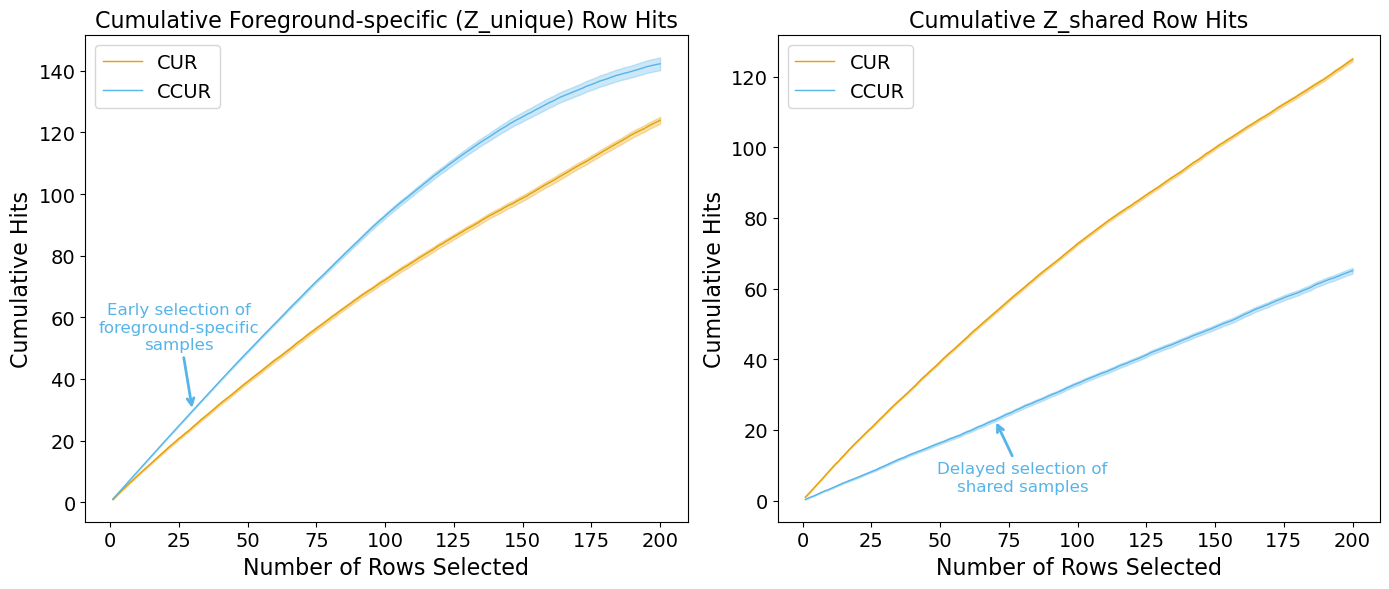

In [36]:
x = np.arange(1, 201)
mean_unique_cur = mean_unique_cur[:200]
mean_unique_ccur = mean_unique_ccur[:200]
mean_shared_cur = mean_shared_cur[:200]
mean_shared_ccur = mean_shared_ccur[:200]

n_sim = 100
stderr_unique_cur  = cum_unique_cur[:, :200].std(axis=0) /np.sqrt(n_sim)
stderr_unique_ccur = cum_unique_ccur[:, :200].std(axis=0)/np.sqrt(n_sim)
stderr_shared_cur   = cum_shared_cur[:, :200].std(axis=0) /np.sqrt(n_sim)
stderr_shared_ccur  = cum_shared_ccur[:, :200].std(axis=0)/np.sqrt(n_sim)

ccur_color = "#56B4E9"  
cur_color  = "#E69F00"  

# Font sizes
title_fontsize = 16
axis_fontsize = 16
tick_fontsize = 14
legend_fontsize = 14

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(x, mean_unique_cur,  label='CUR',  color=cur_color, linestyle='-', linewidth=1)
plt.fill_between(x, 
                 mean_unique_cur - 2*stderr_unique_cur, 
                 mean_unique_cur + 2*stderr_unique_cur, 
                 color=cur_color, alpha=0.3)
plt.plot(x, mean_unique_ccur, label='CCUR', color=ccur_color, linestyle='-', linewidth=1)
plt.fill_between(x, 
                 mean_unique_ccur - 2*stderr_unique_ccur, 
                 mean_unique_ccur + 2*stderr_unique_ccur, 
                 color=ccur_color, alpha=0.3)
plt.title("Cumulative Foreground-specific (Z_unique) Row Hits", fontsize=title_fontsize)
plt.xlabel("Number of Rows Selected", fontsize=axis_fontsize)
plt.ylabel("Cumulative Hits", fontsize=axis_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.legend(fontsize=legend_fontsize)

plt.subplot(1, 2, 2)
plt.plot(x, mean_shared_cur,  label='CUR',  color=cur_color, linestyle='-', linewidth=1)
plt.fill_between(x, 
                 mean_shared_cur - stderr_shared_cur, 
                 mean_shared_cur + stderr_shared_cur, 
                 color=cur_color, alpha=0.3)
plt.plot(x, mean_shared_ccur, label='CCUR', color=ccur_color, linestyle='-', linewidth=1)
plt.fill_between(x, 
                 mean_shared_ccur - stderr_shared_ccur, 
                 mean_shared_ccur + stderr_shared_ccur, 
                 color=ccur_color, alpha=0.3)
plt.title("Cumulative Z_shared Row Hits", fontsize=title_fontsize)
plt.xlabel("Number of Rows Selected", fontsize=axis_fontsize)
plt.ylabel("Cumulative Hits", fontsize=axis_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.legend(fontsize=legend_fontsize)

plt.tight_layout()

# === Annotation for left plot (Z_unique) ===
plt.subplot(1, 2, 1)
plt.annotate(
    "Early selection of\nforeground-specific\nsamples",
    xy=(30, mean_unique_ccur[29]),
    xytext=(25, mean_unique_ccur[29] + 20),
    ha='center',
    arrowprops=dict(arrowstyle="->", color=ccur_color, lw=2),
    fontsize=12, color=ccur_color
)

# === Annotation for right plot (Z_shared) ===
plt.subplot(1, 2, 2)
plt.annotate(
    "Delayed selection of\nshared samples",
    xy=(70, mean_shared_ccur[69]),
    xytext=(80, mean_shared_ccur[69] - 20),
    ha='center',
    arrowprops=dict(arrowstyle="->", color=ccur_color, lw=2),
    fontsize=12, color=ccur_color
)

plt.savefig("row_selection_with_errorbars_annotated.png", dpi=300, bbox_inches='tight')
plt.show()
